<a href="https://colab.research.google.com/github/Percy-O/Breast-Cancer-Prediction/blob/main/Breast_Cancer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
# !pip install mxnet
# !pip install numpy==1.23

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve
from PIL import Image
import numpy as np
import os
import cv2
import glob
import random
from numpy import loadtxt

import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
%matplotlib inline

## Loading Dataset

In [ ]:
df = pd.read_csv('drive/MyDrive/breast_cancer/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,cancer
0,2,10006,462822612,L,CC,61.0,0,29,10006_L,0
1,2,10006,1459541791,L,MLO,61.0,0,29,10006_L,0
2,2,10006,1864590858,R,MLO,61.0,0,29,10006_R,0
3,2,10006,1874946579,R,CC,61.0,0,29,10006_R,0
4,2,10011,220375232,L,CC,55.0,0,21,10011_L,0


In [ ]:
df['cancer'].value_counts()

,count
cancer,
0,53548
1,1158


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   site_id        54706 non-null  int64  
 1   patient_id     54706 non-null  int64  
 2   image_id       54706 non-null  int64  
 3   laterality     54706 non-null  object 
 4   view           54706 non-null  object 
 5   age            54669 non-null  float64
 6   implant        54706 non-null  int64  
 7   machine_id     54706 non-null  int64  
 8   prediction_id  54706 non-null  object 
 9   cancer         54706 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 4.2+ MB


## Using CNN Approach

## Getting the Breast cancer images for both the positive and negative

In [ ]:
POS_DIR = "drive/MyDrive/breast_cancer/1"
NEG_DIR = "drive/MyDrive/breast_cancer/0"

In [ ]:
# negative_images = df[df['cancer'] == 0]
NUM_OF_IMAGES = 12

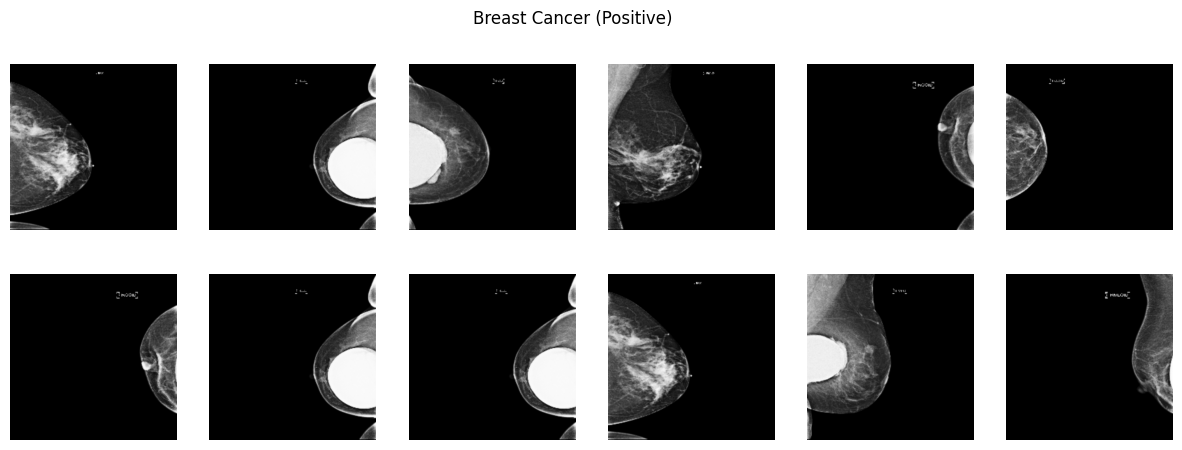

In [ ]:
# Preview Positive images
fig,ax = plt.subplots(2,6,figsize=(15,5))
for i  in range(0,NUM_OF_IMAGES):
    # img_path = os.path.join(IMAGE_DIR, f"{negative_images.iloc[i]['patient_id']}_{negative_images.iloc[i]['image_id']}.png")
    img_path = random.sample(glob.glob(f'{POS_DIR}/*.png'),12)
    img = cv2.imread(img_path[i])
    if img is not None:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax[i//6, i%6].imshow(img)
      ax[i//6, i%6].axis('off')
fig.suptitle('Breast Cancer (Positive)')
plt.show()

In [ ]:
# positive_images = df[df['cancer'] == 1]
NUM_OF_IMAGES = 12

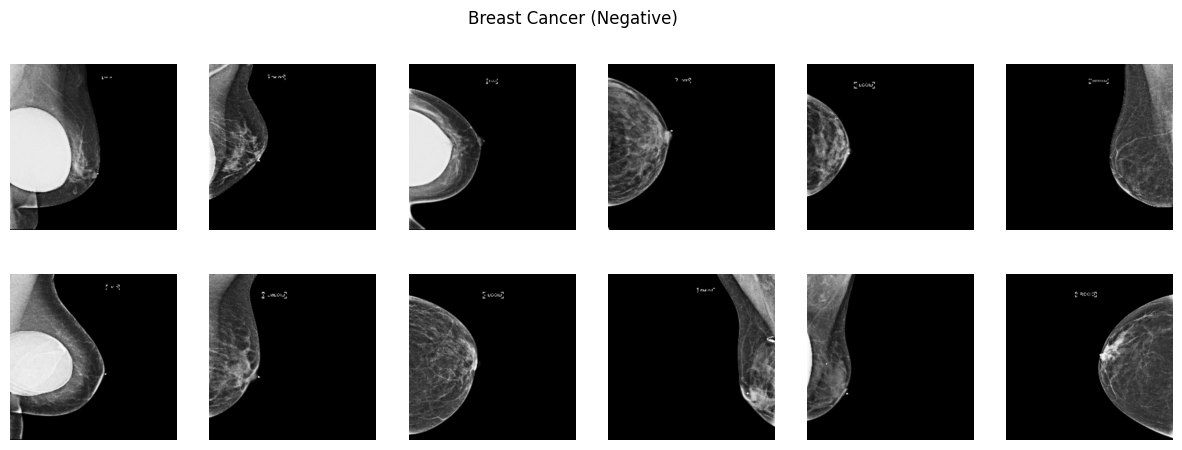

In [ ]:
# Preview Negative images
fig,ax = plt.subplots(2,6,figsize=(15,5))
for i  in range(0,NUM_OF_IMAGES):
    img_path = random.sample(glob.glob(f'{NEG_DIR}/*.png'),12)
    img = cv2.imread(img_path[i])
    if img is not None:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ax[i//6, i%6].imshow(img)
      ax[i//6, i%6].axis('off')
fig.suptitle('Breast Cancer (Negative)')
plt.show()

## Resizing the breast cancer image into 50 by 50
* Taking the resize image as the main data (X data)
* Making the Label to be the Target variable (Negative=0 and Positive = 1)

In [ ]:
Xdata=[]
ylabels=[]
Positive=os.listdir(f"{POS_DIR}/")
for catA in Positive:
  # print(a)
    try:
        image=cv2.imread(f"{POS_DIR}/{catA}")
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        Xdata.append(np.array(size_image))
        ylabels.append(df['cancer'].unique()[1])
    except AttributeError:
        print("")

Negative =os.listdir(f"{NEG_DIR}/")
for catB in Negative:
    try:
        image=cv2.imread(f"{NEG_DIR}/{catB}")
        image_from_array = Image.fromarray(image, 'RGB')
        size_image = image_from_array.resize((50, 50))
        Xdata.append(np.array(size_image))
        ylabels.append(df['cancer'].unique()[0])
    except AttributeError:
        print("")

In [ ]:
X=np.array(Xdata)
y=np.array(ylabels)

In [ ]:
s=np.arange(X.shape[0])
np.random.shuffle(s)
X=X[s]
y=y[s]

In [ ]:
num_classes=len(np.unique(y))
len_data=len(X)

## Normalization
* normalizing data by divinding it by 255.

In [ ]:
# Normalize images
X = X.astype('float32') / 255.0

## Splitting the data in x_train,x_test and labels into y_train and y_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# Convert data to MXNet NDArray
X_train = nd.array(X_train).transpose((0, 3, 1, 2))
X_test = nd.array(X_test).transpose((0, 3, 1, 2))
y_train = nd.array(y_train)
y_test = nd.array(y_test)

## Creating Model

### Define the CNN Model


In [ ]:
# Set context
ctx = mx.gpu() if mx.context.num_gpus() else mx.cpu()

In [ ]:
# Define CNN model
class CNN(nn.Block):
    def __init__(self, **kwargs):
        super(CNN, self).__init__(**kwargs)
        with self.name_scope():
            self.conv1 = nn.Conv2D(channels=32, kernel_size=3, activation='relu')
            self.pool1 = nn.MaxPool2D(pool_size=2, strides=2)
            self.conv2 = nn.Conv2D(channels=64, kernel_size=3, activation='relu')
            self.pool2 = nn.MaxPool2D(pool_size=2, strides=2)
            self.flatten = nn.Flatten()
            self.fc1 = nn.Dense(128, activation='relu')
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Dense(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Create and Initialize the Model


In [ ]:
net = CNN()
net.initialize(mx.init.Xavier(), ctx=ctx)

### Define Loss Function and Optimizer


In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})

### Training Function

In [ ]:
# Training function
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
def train(net, train_data, valid_data, epochs, batch_size, ctx):
    train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(*train_data), batch_size=batch_size, shuffle=True)
    valid_data = gluon.data.DataLoader(gluon.data.ArrayDataset(*valid_data), batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        train_loss = 0.
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                loss = loss_fn(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_loss += loss.mean().asscalar()

        valid_loss = 0.
        for data, label in valid_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            output = net(data)
            loss = loss_fn(output, label)
            valid_loss += loss.mean().asscalar()

        train_loss /= len(train_data)
        valid_loss /= len(valid_data)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f"Epoch {epoch + 1}, Loss: {train_loss/len(train_data)}, Validation Loss: {valid_loss/len(valid_data)}")


In [ ]:
# Train the model
train(net, (X_train, y_train), (X_test, y_test), epochs=10, batch_size=32, ctx=ctx)

Epoch 1, Loss: 0.09016712148698706, Validation Loss: 0.003376266349934869
Epoch 2, Loss: 0.0008954629163949629, Validation Loss: 0.0006976908326679324
Epoch 3, Loss: 0.0003279631097551019, Validation Loss: 0.0006060595514504206
Epoch 4, Loss: 0.00015182906166105327, Validation Loss: 0.0005309865424704994
Epoch 5, Loss: 5.836894210299963e-05, Validation Loss: 0.0002164284764110865
Epoch 6, Loss: 6.579497987381936e-05, Validation Loss: 0.0004354058430067198
Epoch 7, Loss: 6.312949657765742e-05, Validation Loss: 6.131306252399327e-05
Epoch 8, Loss: 8.349039123964261e-05, Validation Loss: 7.684371537249508e-05
Epoch 9, Loss: 1.91905513107871e-05, Validation Loss: 0.00027977961874468984
Epoch 10, Loss: 0.00019435501190216272, Validation Loss: 4.62699669393866e-05


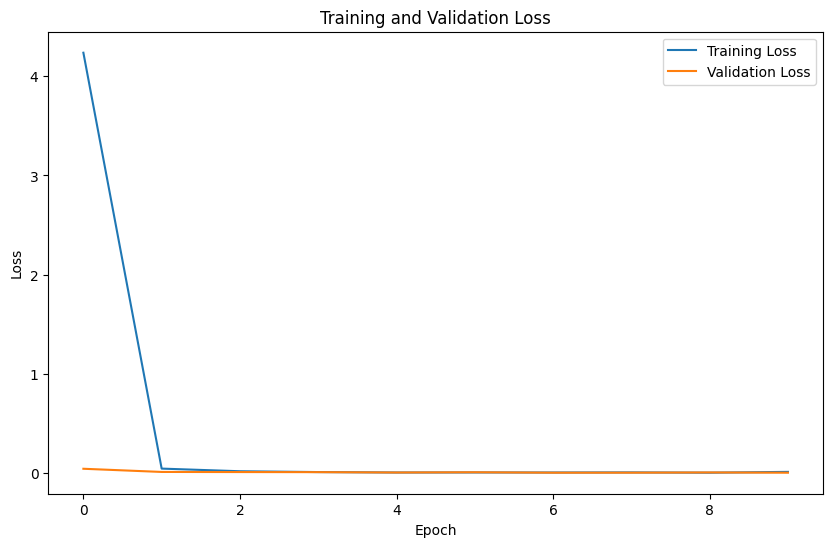

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Evaluate the Model

In [ ]:
# Evaluate the model
def evaluate_accuracy(data_iterator, net, ctx):
    acc = mx.metric.Accuracy()
    for data, label in data_iterator:
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [ ]:
train_dt = gluon.data.DataLoader(gluon.data.ArrayDataset(X_train, y_train), batch_size=32, shuffle=False)
train_accuracy = evaluate_accuracy(train_dt, net, ctx)
print(f"Train Accuracy: {train_accuracy * 100}%")

Train Accuracy: 100.0%


In [ ]:
test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X_test, y_test), batch_size=32, shuffle=False)
test_accuracy = evaluate_accuracy(test_data, net, ctx)
print(f"Test Accuracy: {test_accuracy * 100}%")

Test Accuracy: 100.0%


## Save Model

In [ ]:
#Save the model
net.save_parameters('breast_model.params')
print("Model parameters saved to cnn_model.params")

Model parameters saved to cnn_model.params


## Visualizing CNN Performance

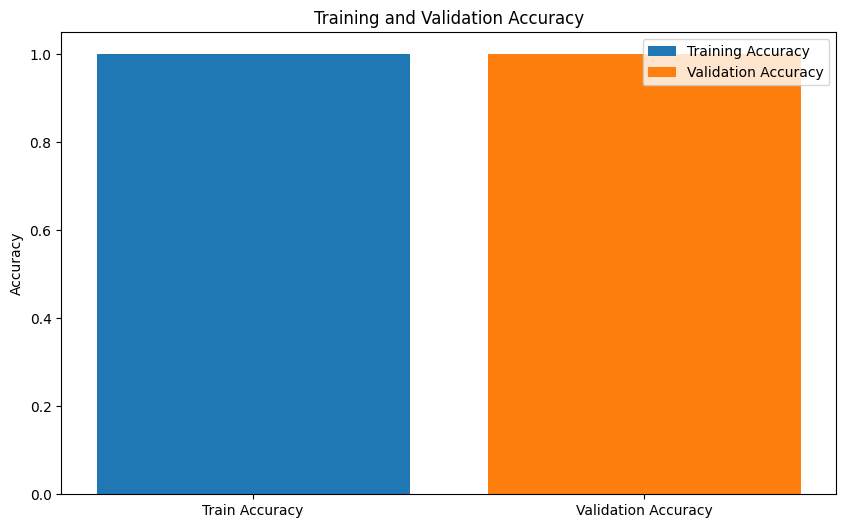

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
train_accuracy = evaluate_accuracy(train_dt, net, ctx)
test_accuracy = evaluate_accuracy(test_data, net, ctx)
plt.bar(['Train Accuracy'],train_accuracy, label='Training Accuracy')
plt.bar(['Validation Accuracy'],test_accuracy, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Performance Evaluation

In [ ]:
y_pred = []
y_true = []

for data, label in test_data:
    data = data.as_in_context(ctx)
    label = label.as_in_context(ctx)
    output = net(data)
    predictions = nd.argmax(output, axis=1)
    y_pred.extend(predictions.asnumpy())
    y_true.extend(label.asnumpy())

Accuracy Score: 100.0
F1 Score: 100.0
Recall Score: 100.0
Precision Score: 100.0


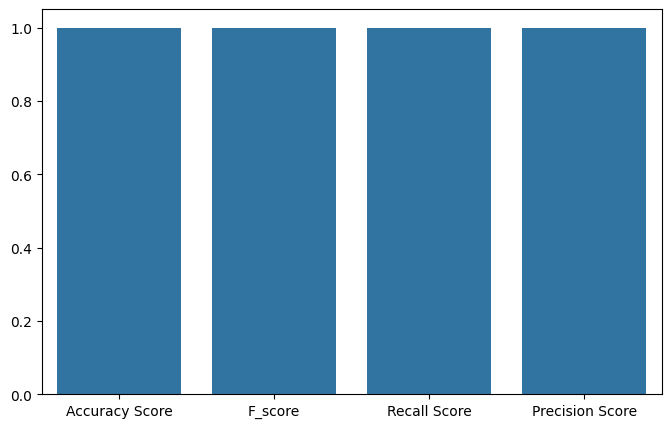

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,precision_score, roc_curve, auc
import seaborn as sns

a_score = accuracy_score(y_true,y_pred)
f_score = f1_score(y_true,y_pred)
r_score = recall_score(y_true,y_pred)
p_score = precision_score(y_true,y_pred)

print('Accuracy Score:',a_score * 100)
print('F1 Score:',f_score * 100)
print('Recall Score:',r_score * 100)
print('Precision Score:',p_score * 100)

plt.figure(figsize = (8,5))
sns.barplot(x=['Accuracy Score','F_score','Recall Score','Precision Score'],y=[a_score,f_score,r_score,p_score])
plt.show()


## COnfusion Matrix

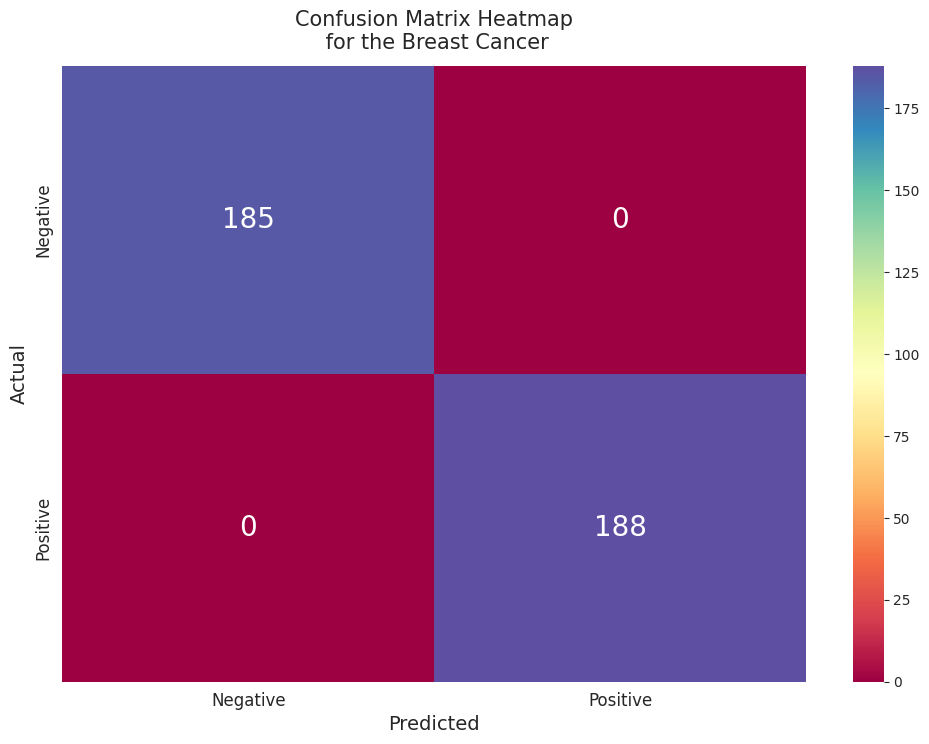

In [ ]:
conf_mat = confusion_matrix(y_true,y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n for the Breast Cancer', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['Negative','Positive'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['Negative','Positive'], fontdict={'fontsize':12})
plt.show()

### ROC Curve

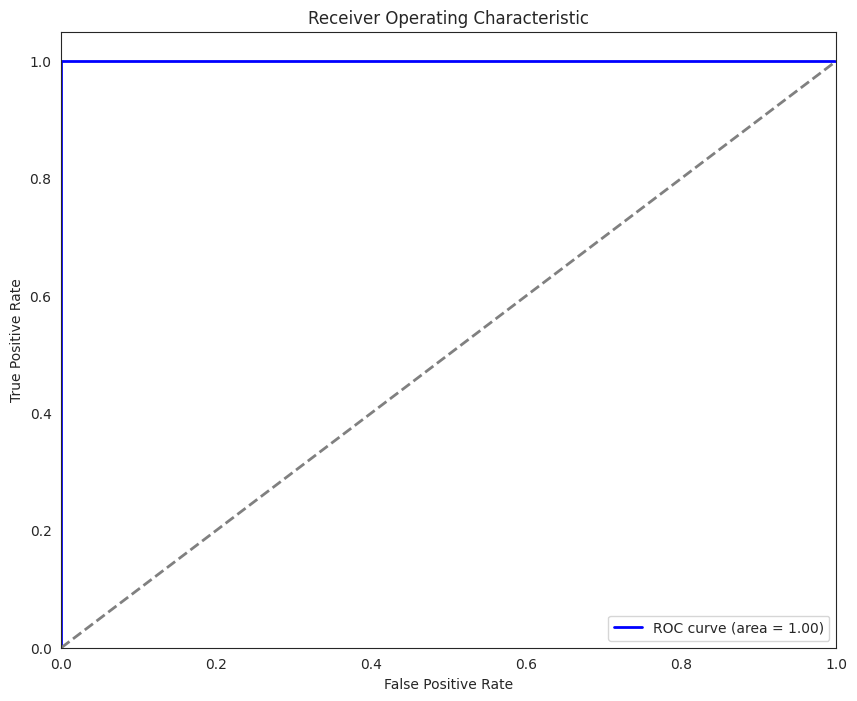

In [ ]:
# ROC Curve
y_score = []

for data, label in test_data:
    data = data.as_in_context(ctx)
    output = net(data)
    y_score.extend(output.softmax().asnumpy()[:, 1])

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()